In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import normalize_data
import random
import train

pd.set_option('display.max_columns', 999)
pd.set_option('display.precision', 10)

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
raw_data = {} # loads raw data and stores as a dict cache

def dataset_key(dataset='', validation=False):
    return dataset+('test' if validation else 'train')


def load_data(raw, dataset='', validation=False):
    '''
    Return dataframe matching data set and validation. Dictionary input will be updated.

    Parameters
    ----------
    raw : dict
        dictionary which caches the dataframes and will be updated accordingly

    dataset : str
        which dataset to use? valid input includes: empty str for full set, sample_, and secret_

    validation : bool
        load validation set? if true then use _test, otherwise use _train.  Note secret_ doesn't have _train
    '''
    key = dataset+('test' if validation else 'train')
    if key not in raw:
        print(f"Loading data to cache for: {key}")
        raw[key] = pd.read_pickle(f'{os.environ["GP_HIST_PATH"]}/../t4_data/{key}.pkl')
    return raw[key]

In [4]:
configurations = {
    'dataset' : 'sample_', # '', 'sample_', 'secret_'
    'model_identifier' : "all_go_0",
    'model_path' : f"{os.environ['GP_HIST_PATH']}/../t4_models",
    'device' : 'cpu',
    'random_seed' : 0,
    'lr' : 1e-5,
    'momentum' : 0.97, #SGD
    'weight_decay' : 1e-7, #Adam
    'max_epochs' : 5000,
    'do_validate' : True,
    'model_definition' : [
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300), ('relu1', None), ('drop', 0.3),
        ('layer', 300), ('relu1', None),
        ('layer', 300),
    ],
    'train_params' : {
        'batch_size': 50000,
        'shuffle': True,
        'num_workers': 3,
        'pin_memory': True,
    },
    'test_params' : {
        'batch_size': 200000,
        'num_workers': 2,
        'pin_memory': True,
    },
}

In [5]:
%%time

train_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=False))
test_df = normalize_data.normalize_all_columns(load_data(raw_data,dataset=configurations['dataset'],validation=True))

train_df = train_df.dropna()
test_df = test_df.dropna()
# train_df = train_df.sample(100000, random_state=42)
# test_df = test_df.sample(10000, random_state=42)

Loading data to cache for: sample_train
Loading data to cache for: sample_test
CPU times: user 710 ms, sys: 708 ms, total: 1.42 s
Wall time: 1.13 s


In [6]:
ref_train, X_train, y_train = get_ref_X_y(train_df)
ref_test, X_test, y_test = get_ref_X_y(test_df)

In [18]:
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_RA_OF_ASC_NODE', 'y_ARG_OF_PERICENTER_REG', 'y_ARG_OF_PERICENTER', 'y_BSTAR', 'y_REV_MA_REG', 'y_MEAN_ANOMALY']
y_cols = ['y_INCLINATION', 'y_ECCENTRICITY', 'y_MEAN_MOTION', 'y_RA_OF_ASC_NODE_REG', 'y_ARG_OF_PERICENTER_REG', 'y_REV_MA_REG']

y_train = y_train[y_cols]
y_test = y_test[y_cols]

# y_train = np.sign(y_train) * np.log(1+np.abs(y_train))
# y_test = np.sign(y_test) * np.log(1+np.abs(y_test))

In [19]:
# model, mean_losses = train.train_model(X_train, y_train, X_test, y_test, configurations, force_train=False)

Loading existing model


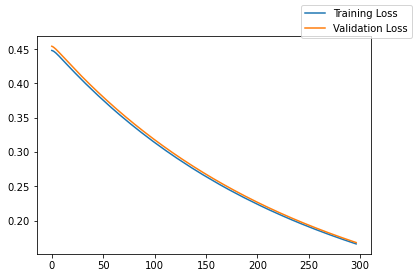

In [32]:
model, _, _, mean_losses, _ = train.load_model_with_config(configurations)

tl, vl = zip(*mean_losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [25]:
trained_model = model

In [26]:
sample_idx = random.sample(list(X_test.index), 10000)

X_sample = X_test.loc[sample_idx]
y_sample = y_test.loc[sample_idx]

In [27]:
# y_train_pred = train.predict(trained_model, X_train, y_train, device="cpu") # get predictions for each train
# y_train_pred_df = pd.DataFrame(y_train_pred, columns=y_train.columns)  # put results into a dataframe
y_sample_pred = train.predict(trained_model, X_sample, y_sample, device="cpu") # get predictions for each train
y_sample_pred_df = pd.DataFrame(y_sample_pred, columns=y_sample.columns)  # put results into a dataframe

In [28]:
print(f'    Test set MAE (L1) loss: {mean_absolute_error(y_sample, y_sample_pred_df)}')
print(f'    Test set MSE (L2) loss: {mean_squared_error(y_sample, y_sample_pred_df)}')

# random.seed(342798)
sample = random.sample(list(y_sample_pred_df.index), 10)
# sample = [0,1]

print("Test - Ground Truth (normalized):")
display(y_sample)
print("Test - Prediction (normalized):")
display(y_sample_pred_df)
# print("Ground Truth Diffs from X_:")
# display(y_sample - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)
# print("Pred Diffs from X_:")
# display(y_sample_pred_df - X_sample[['X_INCLINATION_1','X_ECCENTRICITY_1','X_MEAN_MOTION_1']].values)


    Test set MAE (L1) loss: 0.46736873025919773
    Test set MSE (L2) loss: 0.2478556252935575
Test - Ground Truth (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
40604,0.1612533333,0.0684256,0.4299410491,0.8597369444,0.5354641667,1.1162608889
74360,0.4514794444,0.0208928,0.3281824823,0.6916088889,-0.0094111111,0.4001070679
57467,0.5500977778,0.0652508,0.3675949246,0.4075941667,0.3294722222,0.8408383025
74252,0.5403272222,0.0113420,0.5106304274,0.2582180556,0.2471941667,1.1428504074
36851,0.1612411111,0.0416792,0.4568706023,0.8643822222,0.9249041667,0.1897064012
...,...,...,...,...,...,...
73857,0.5403550000,0.0455956,0.4314855131,0.0888752778,0.4188713889,1.1398141358
61384,0.5480605556,0.0398472,0.3391520114,0.4064505556,0.5587166667,0.4826718025
54116,0.5501122222,0.0650544,0.3665134743,0.0347286111,0.6515991667,0.6038276389
64326,0.5484683333,0.0405184,0.3392231509,0.5534533333,0.2577586111,0.9638419815


Test - Prediction (normalized):


,y_INCLINATION,y_ECCENTRICITY,y_MEAN_MOTION,y_RA_OF_ASC_NODE_REG,y_ARG_OF_PERICENTER_REG,y_REV_MA_REG
0,0.6156357527,0.4041008651,1.0329172611,0.5826737881,-0.0040533841,0.3164267242
1,0.9058792591,0.3565830588,0.9312114716,0.3014331460,-0.3363471627,0.6441178322
2,1.0044879913,0.4008008242,0.9706180692,-0.0048134625,0.0259880126,0.2856169045
3,0.9947254658,0.3499012887,1.1064600945,-0.1576902419,-0.0636562109,-0.2032507360
4,0.6156475544,0.3775153756,1.0599030256,0.4881129563,0.5467417240,-0.2415197045
...,...,...,...,...,...,...
9995,0.9947546721,0.3811232448,1.0341398716,-0.3258831501,0.1375294924,0.1708248556
9996,1.0024722815,0.3754825294,0.9421821237,0.0011384189,0.2368568778,0.0692515969
9997,1.0045095682,0.4006815553,0.9695385695,-0.3733826280,0.3364862204,-0.0334926248
9998,1.0028553009,0.3761910200,0.9422463179,0.1397524774,-0.0400024354,0.3509512544


In [ ]:
# print(f'    Train set MAE (L1) loss: {mean_absolute_error(y_train, y_train_pred_df)}')
# print(f'    Train set MSE (L2) loss: {mean_squared_error(y_train, y_train_pred_df)}')

# random.seed(0)
# sample = random.sample(list(y_train_pred_df.index), 10)

# print("Train - Ground Truth (normalized):")
# display(y_train.loc[sample])
# # print("Train - Ground Truth (non-normalized):")
# # display(normalize_data.normalize_all_columns(y_train.iloc[:,3:].loc[sample].copy(), reverse=True))  # see ground truths
# print("Train - Prediction (normalized):")
# display(y_train_pred_df.loc[sample])
# # print("Train - Prediction (non-normalized):")
# # display(normalize_data.normalize_all_columns(y_train_pred_df.loc[sample].copy(), reverse=True))  # See predictions

In [ ]:
# errors = y_train.loc[sample].iloc[:,3:] - y_train_pred_df.loc[sample]

# display(errors)

# display(errors.std())

# display(y_train.loc[sample].iloc[:,3:])
# display(y_train_pred_df.loc[sample])

In [ ]:
# def row_to_compare(X, y, y_pred, row):
#     epoch = X.iloc[row].EPOCH_y
#     X0 = clean_data.normalize_all_columns(X_train.iloc[row].copy(), reverse=True)
#     y0 = clean_data.normalize_all_columns(y_train.iloc[row].copy(), reverse=True)
#     y1 = clean_data.normalize_all_columns(y_train_pred_df.iloc[row].copy(), reverse=True)

#     # Ground truth
#     y0_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y0.ECCENTRICITY,
#                                           aop=y0.ARG_OF_PERICENTER,
#                                           inc=y0.INCLINATION,
#                                           mea=y0.MEAN_ANOMALY,
#                                           mem=y0.MEAN_MOTION,
#                                           raa=y0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Prediction
#     y1_xyz = clean_data.get_satellite_xyz(bst=0.0001,
#                                           ecc=y1.ECCENTRICITY,
#                                           aop=y1.ARG_OF_PERICENTER,
#                                           inc=y1.INCLINATION,
#                                           mea=y1.MEAN_ANOMALY,
#                                           mem=y1.MEAN_MOTION,
#                                           raa=y1.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     # Propigation
#     y2_xyz = clean_data.get_satellite_xyz(bst=X0.BSTAR,
#                                           ecc=X0.ECCENTRICITY,
#                                           aop=X0.ARG_OF_PERICENTER,
#                                           inc=X0.INCLINATION,
#                                           mea=X0.MEAN_ANOMALY,
#                                           mem=X0.MEAN_MOTION,
#                                           raa=X0.RA_OF_ASC_NODE,
#                                           epoch=epoch,)
#     print(f'Ground Truth: {y0_xyz}')
#     print(f'Predicted: {y1_xyz}')
#     print(f'Propigation: {y2_xyz}')
    
#     print (f'Prediction Error: {sum((y1_xyz-y0_xyz)**2)**0.5} km')
#     print (f'Propigation Error: {sum((y2_xyz-y0_xyz)**2)**0.5} km')
    

# for row in range(2):
#     print (f'Row {row}:')
#     row_to_compare(X_train, y_train, y_train_pred_df, row)
#     print('')